In [51]:
from IPython.utils import io
import os
import subprocess
import tqdm.notebook

TQDM_BAR_FORMAT = '{l_bar}{bar}| {n_fmt}/{total_fmt} [elapsed: {elapsed} remaining: {remaining}]'


In [52]:
import torch
from botorch import fit_gpytorch_model
from botorch.acquisition import UpperConfidenceBound
from botorch.models import SingleTaskGP
from botorch.optim import optimize_acqf
from gpytorch.mlls import ExactMarginalLogLikelihood
from gpytorch.kernels import RBFKernel, ScaleKernel
import numpy as np
import matplotlib.pyplot as plt

# 目的関数の用意

In [53]:
def rosenbrock(x):
    return torch.sum(100.0 * (x[..., 1:] - x[..., :-1]**2)**2 + (1 - x[..., :-1])**2, dim=-1)

In [54]:


# rosenbrockを使う場合
global_optimum = 0.0

# 初期点の生成関数

In [55]:
def generate_initial_points(n_initial, dim, bounds):
    return torch.rand(n_initial, dim) * (bounds[1] - bounds[0]) + bounds[0]

# モデル作成関数


In [56]:
def create_model(train_X, train_Y):
    kernel = ScaleKernel(RBFKernel(ard_num_dims=train_X.shape[-1]))
    model = SingleTaskGP(train_X, train_Y, covar_module=kernel)
    return model


# **ドロップアウトベイズクラス(Dropout-mix)**

In [57]:
class DropoutMixBO_Mix:
    def __init__(self, dim, active_dim, bounds, n_initial, dropout_prob=0.1):
        self.dim = dim
        self.active_dim = active_dim
        self.bounds = bounds
        self.dropout_prob = dropout_prob
        self.X = generate_initial_points(n_initial, dim, bounds)
        self.Y = rosenbrock(self.X)
        self.best_f = self.Y.min().item()
        self.best_x = self.X[self.Y.argmin()]
        self.eval_history = [self.best_f] * n_initial

    def optimize(self, n_iter):
        for _ in range(n_iter):
            # 全次元からランダムにactive_dim個選ぶ
            active_dims = np.random.choice(self.dim, self.active_dim, replace=False)

            train_X = self.X[:, active_dims]
            train_Y = self.Y.unsqueeze(-1)
            model = create_model(train_X, train_Y)
            mll = ExactMarginalLogLikelihood(model.likelihood, model)
            fit_gpytorch_model(mll)

            UCB = UpperConfidenceBound(model, beta=0.1)
            bounds_active = torch.stack([self.bounds[0][active_dims], self.bounds[1][active_dims]])
            candidate, _ = optimize_acqf(
                UCB, bounds=bounds_active, q=1, num_restarts=5, raw_samples=20,
            )

            x_new = torch.zeros(self.dim)
            if np.random.random() < self.dropout_prob:
                x_new[active_dims] = candidate.squeeze()
                inactive_dims = np.setdiff1d(range(self.dim), active_dims)
                x_new[inactive_dims] = (torch.rand(len(inactive_dims))
                                        * (self.bounds[1][inactive_dims] - self.bounds[0][inactive_dims])
                                        + self.bounds[0][inactive_dims])
            else:
                x_new[active_dims] = candidate.squeeze()
                x_new[np.setdiff1d(range(self.dim), active_dims)] = self.best_x[
                    np.setdiff1d(range(self.dim), active_dims)]

            y_new = rosenbrock(x_new.unsqueeze(0))

            self.X = torch.cat([self.X, x_new.unsqueeze(0)])
            self.Y = torch.cat([self.Y, y_new])

            if y_new < self.best_f:
                self.best_f = y_new.item()
                self.best_x = x_new

            self.eval_history.append(self.best_f)

        return self.best_x, self.best_f

# **ドロップアウトベイズクラス(p=0)(Dropout_copy)**

In [58]:
class DropoutMixBO_Copy:
    def __init__(self, dim, active_dim, bounds, n_initial, dropout_prob=0.0):
        self.dim = dim
        self.active_dim = active_dim
        self.bounds = bounds
        self.dropout_prob = dropout_prob
        self.X = generate_initial_points(n_initial, dim, bounds)
        self.Y = rosenbrock(self.X)
        self.best_f = self.Y.min().item()
        self.best_x = self.X[self.Y.argmin()]
        self.eval_history = [self.best_f] * n_initial

    def optimize(self, n_iter):
        for _ in range(n_iter):
            # 全次元からランダムにactive_dim個選ぶ
            active_dims = np.random.choice(self.dim, self.active_dim, replace=False)

            train_X = self.X[:, active_dims]
            train_Y = self.Y.unsqueeze(-1)
            model = create_model(train_X, train_Y)
            mll = ExactMarginalLogLikelihood(model.likelihood, model)
            fit_gpytorch_model(mll)

            UCB = UpperConfidenceBound(model, beta=0.1)
            bounds_active = torch.stack([self.bounds[0][active_dims], self.bounds[1][active_dims]])
            candidate, _ = optimize_acqf(
                UCB, bounds=bounds_active, q=1, num_restarts=5, raw_samples=20,
            )

            x_new = torch.zeros(self.dim)
            if np.random.random() < self.dropout_prob:
                x_new[active_dims] = candidate.squeeze()
                inactive_dims = np.setdiff1d(range(self.dim), active_dims)
                x_new[inactive_dims] = (torch.rand(len(inactive_dims))
                                        * (self.bounds[1][inactive_dims] - self.bounds[0][inactive_dims])
                                        + self.bounds[0][inactive_dims])
            else:
                x_new[active_dims] = candidate.squeeze()
                x_new[np.setdiff1d(range(self.dim), active_dims)] = self.best_x[
                    np.setdiff1d(range(self.dim), active_dims)]

            y_new = rosenbrock(x_new.unsqueeze(0))

            self.X = torch.cat([self.X, x_new.unsqueeze(0)])
            self.Y = torch.cat([self.Y, y_new])

            if y_new < self.best_f:
                self.best_f = y_new.item()
                self.best_x = x_new

            self.eval_history.append(self.best_f)

        return self.best_x, self.best_f

# **ドロップアウトベイズクラス(p=1)(Dropout-Random)**

In [59]:
class DropoutMixBO_Random:
    def __init__(self, dim, active_dim, bounds, n_initial, dropout_prob=1.0):
        self.dim = dim
        self.active_dim = active_dim
        self.bounds = bounds
        self.dropout_prob = dropout_prob
        self.X = generate_initial_points(n_initial, dim, bounds)
        self.Y = rosenbrock(self.X)
        self.best_f = self.Y.min().item()
        self.best_x = self.X[self.Y.argmin()]
        self.eval_history = [self.best_f] * n_initial

    def optimize(self, n_iter):
        for _ in range(n_iter):
            # 全次元からランダムにactive_dim個選ぶ
            active_dims = np.random.choice(self.dim, self.active_dim, replace=False)

            train_X = self.X[:, active_dims]
            train_Y = self.Y.unsqueeze(-1)
            model = create_model(train_X, train_Y)
            mll = ExactMarginalLogLikelihood(model.likelihood, model)
            fit_gpytorch_model(mll)

            UCB = UpperConfidenceBound(model, beta=0.1)
            bounds_active = torch.stack([self.bounds[0][active_dims], self.bounds[1][active_dims]])
            candidate, _ = optimize_acqf(
                UCB, bounds=bounds_active, q=1, num_restarts=5, raw_samples=20,
            )

            x_new = torch.zeros(self.dim)
            if np.random.random() < self.dropout_prob:
                x_new[active_dims] = candidate.squeeze()
                inactive_dims = np.setdiff1d(range(self.dim), active_dims)
                x_new[inactive_dims] = (torch.rand(len(inactive_dims))
                                        * (self.bounds[1][inactive_dims] - self.bounds[0][inactive_dims])
                                        + self.bounds[0][inactive_dims])
            else:
                x_new[active_dims] = candidate.squeeze()
                x_new[np.setdiff1d(range(self.dim), active_dims)] = self.best_x[
                    np.setdiff1d(range(self.dim), active_dims)]

            y_new = rosenbrock(x_new.unsqueeze(0))

            self.X = torch.cat([self.X, x_new.unsqueeze(0)])
            self.Y = torch.cat([self.Y, y_new])

            if y_new < self.best_f:
                self.best_f = y_new.item()
                self.best_x = x_new

            self.eval_history.append(self.best_f)

        return self.best_x, self.best_f

# REMBO

In [60]:
class REMBO:
    def __init__(self, high_dim, low_dim, bounds, n_initial):
        self.high_dim = high_dim
        self.low_dim = low_dim
        self.bounds = bounds
        self.X = torch.randn(n_initial, low_dim) * 2 - 1
        self.A = torch.randn(high_dim, low_dim)
        self.X_high = torch.clamp(torch.matmul(self.X, self.A.t()), bounds[0], bounds[1])
        self.Y = rosenbrock(self.X_high)
        self.best_f = self.Y.min().item()
        self.best_x = self.X_high[self.Y.argmin()]
        self.eval_history = [self.best_f] * n_initial

    def optimize(self, n_iter):
        for _ in range(n_iter):
            # イテレーションごとにランダムな行列を生成
            self.A = torch.randn(self.high_dim, self.low_dim)
            self.X_high = torch.clamp(torch.matmul(self.X, self.A.t()), self.bounds[0], self.bounds[1])
            self.Y = rosenbrock(self.X_high)

            train_X = self.X
            train_Y = self.Y.unsqueeze(-1)
            model = create_model(train_X, train_Y)
            mll = ExactMarginalLogLikelihood(model.likelihood, model)
            fit_gpytorch_model(mll)

            UCB = UpperConfidenceBound(model, beta=0.1)
            bounds_low = torch.stack([torch.ones(self.low_dim) * -1, torch.ones(self.low_dim)])
            candidate, _ = optimize_acqf(
                UCB, bounds=bounds_low, q=1, num_restarts=5, raw_samples=20,
            )

            x_low = candidate.squeeze()
            x_high = torch.clamp(torch.matmul(x_low.unsqueeze(0), self.A.t()), self.bounds[0], self.bounds[1]).squeeze()

            y_new = rosenbrock(x_high.unsqueeze(0))

            self.X = torch.cat([self.X, x_low.unsqueeze(0)])
            self.X_high = torch.cat([self.X_high, x_high.unsqueeze(0)])
            self.Y = torch.cat([self.Y, y_new])

            if y_new < self.best_f:
                self.best_f = y_new.item()
                self.best_x = x_high

            self.eval_history.append(self.best_f)

        return self.best_x, self.best_f

# バンディットアルゴリズムを用いたドロップアウトベイズクラス

In [61]:
class DropoutMixBO_Bandit:
    def __init__(self, dim, active_dim, bounds, n_initial, dropout_prob=0.1):
        self.dim = dim
        self.active_dim = active_dim
        self.bounds = bounds
        self.dropout_prob = dropout_prob
        self.X = generate_initial_points(n_initial, dim, bounds)
        self.Y = rosenbrock(self.X)
        self.best_f = self.Y.min().item()
        self.best_x = self.X[self.Y.argmin()]
        self.eval_history = [self.best_f] * n_initial
        
        # バンディットアルゴリズム用の変数
        self.dim_counts = np.zeros(dim)
        self.dim_rewards = np.zeros(dim)
        self.total_pulls = 0

    

    def select_active_dims(self):
        ucb_scores = self.dim_rewards / (self.dim_counts + 1e-5) + np.sqrt(2 * np.log(self.total_pulls + 1) / (self.dim_counts + 1e-5))
        return np.argsort(ucb_scores)[-self.active_dim:]

    def update_bandit(self, selected_dims, reward):
        self.dim_counts[selected_dims] += 1
        self.dim_rewards[selected_dims] += reward
        self.total_pulls += 1

    def optimize(self, n_iter):
        for _ in range(n_iter):
            active_dims = self.select_active_dims()

            train_X = self.X[:, active_dims]
            train_Y = self.Y.unsqueeze(-1)
            model = create_model(train_X, train_Y)
            mll = ExactMarginalLogLikelihood(model.likelihood, model)
            fit_gpytorch_model(mll)

            UCB = UpperConfidenceBound(model, beta=0.1)
            bounds_active = torch.stack([self.bounds[0][active_dims], self.bounds[1][active_dims]])
            candidate, _ = optimize_acqf(
                UCB, bounds=bounds_active, q=1, num_restarts=5, raw_samples=20,
            )

            x_new = torch.zeros(self.dim)
            if np.random.random() < self.dropout_prob:
                x_new[active_dims] = candidate.squeeze()
                inactive_dims = np.setdiff1d(range(self.dim), active_dims)
                x_new[inactive_dims] = (torch.rand(len(inactive_dims))
                                        * (self.bounds[1][inactive_dims] - self.bounds[0][inactive_dims])
                                        + self.bounds[0][inactive_dims])
            else:
                x_new[active_dims] = candidate.squeeze()
                x_new[np.setdiff1d(range(self.dim), active_dims)] = self.best_x[
                    np.setdiff1d(range(self.dim), active_dims)]

            y_new = rosenbrock(x_new.unsqueeze(0))

            self.X = torch.cat([self.X, x_new.unsqueeze(0)])
            self.Y = torch.cat([self.Y, y_new])

            improvement = max(self.best_f - y_new.item(), 0)
            self.update_bandit(active_dims, improvement)

            if y_new < self.best_f:
                self.best_f = y_new.item()
                self.best_x = x_new

            self.eval_history.append(self.best_f)

        return self.best_x, self.best_f

    

# 最適化の実行


In [62]:
dim = 25
active_dim = 5
bounds = torch.tensor([[-5.0] * dim, [5.0] * dim])
n_initial = 200
n_iter = 1500

In [63]:
dropout_bo_mix = DropoutMixBO_Mix(dim, active_dim, bounds, n_initial)
dropout_bo_copy = DropoutMixBO_Copy(dim, active_dim, bounds, n_initial)
dropout_bo_random = DropoutMixBO_Random(dim, active_dim, bounds, n_initial)
dropout_bandit = DropoutMixBO_Bandit(dim, active_dim, bounds, n_initial)
rembo = REMBO(dim, active_dim, bounds, n_initial)

In [64]:
try:
  with tqdm.notebook.tqdm(total=100, bar_format=TQDM_BAR_FORMAT) as pbar:
    with io.capture_output() as captured:
      dropout_mix_best_x , dropout_mix_best_f = dropout_bo_mix.optimize(n_iter)
      pbar.update(20)
      dropout_copy_best_x , dropout_copy_best_f = dropout_bo_copy.optimize(n_iter)
      pbar.update(20)
      dropout_random_best_x , dropout_random_best_f = dropout_bo_random.optimize(n_iter)
      pbar.update(20)
      rembo_best_x, rembo_best_f = rembo.optimize(n_iter)
      pbar.update(20) 
      dropout_bandit_best_x, dropout_bandit_best_f = dropout_bandit.optimize(n_iter)
      pbar.update(20)      
    
except subprocess.CalledProcessError:
  print(captured)
  raise

  0%|          | 0/100 [elapsed: 00:00 remaining: ?]

# 結果のプロット

C:\Users\nomuyu\Documents\baysian_optimization\.venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 12288 (\N{IDEOGRAPHIC SPACE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


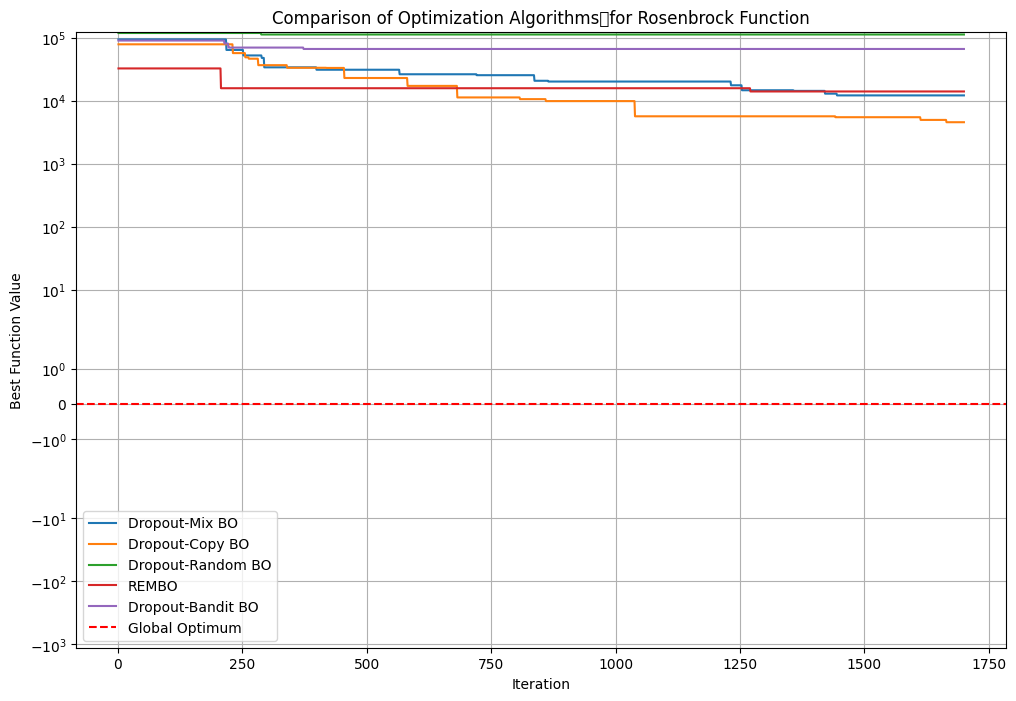

In [65]:
plt.figure(figsize=(12, 8))
plt.plot(range(1, n_initial + n_iter + 1), dropout_bo_mix.eval_history, label='Dropout-Mix BO')
plt.plot(range(1, n_initial + n_iter + 1), dropout_bo_copy.eval_history, label='Dropout-Copy BO')
plt.plot(range(1, n_initial + n_iter + 1), dropout_bo_random.eval_history, label='Dropout-Random BO')
plt.plot(range(1, n_initial + n_iter + 1), rembo.eval_history, label='REMBO')
plt.plot(range(1, n_initial + n_iter + 1), dropout_bandit.eval_history, label='Dropout-Bandit BO')
plt.axhline(y=global_optimum, color='r', linestyle='--', label='Global Optimum')
plt.xlabel('Iteration')
plt.ylabel('Best Function Value')
plt.title('Comparison of Optimization Algorithms　for Rosenbrock Function')
plt.legend()
plt.yscale('symlog')
plt.grid(True)
plt.show()

# Styblinski-Tang関数を使うver

In [66]:
def styblinski_tang(x):
    return 0.5 * torch.sum(x ** 4 - 16 * x ** 2 + 5 * x, dim=-1)

In [67]:
global_optimum = -39.16599 * 25

# **ドロップアウトベイズクラス(Dropout-mix)**

In [68]:
class DropoutMixBO_Mix:
    def __init__(self, dim, active_dim, bounds, n_initial, dropout_prob=0.1):
        self.dim = dim
        self.active_dim = active_dim
        self.bounds = bounds
        self.dropout_prob = dropout_prob
        self.X = generate_initial_points(n_initial, dim, bounds)
        self.Y = styblinski_tang(self.X)
        self.best_f = self.Y.min().item()
        self.best_x = self.X[self.Y.argmin()]
        self.eval_history = [self.best_f] * n_initial

    def optimize(self, n_iter):
        for _ in range(n_iter):
            # 全次元からランダムにactive_dim個選ぶ
            active_dims = np.random.choice(self.dim, self.active_dim, replace=False)

            train_X = self.X[:, active_dims]
            train_Y = self.Y.unsqueeze(-1)
            model = create_model(train_X, train_Y)
            mll = ExactMarginalLogLikelihood(model.likelihood, model)
            fit_gpytorch_model(mll)

            UCB = UpperConfidenceBound(model, beta=0.1)
            bounds_active = torch.stack([self.bounds[0][active_dims], self.bounds[1][active_dims]])
            candidate, _ = optimize_acqf(
                UCB, bounds=bounds_active, q=1, num_restarts=5, raw_samples=20,
            )

            x_new = torch.zeros(self.dim)
            if np.random.random() < self.dropout_prob:
                x_new[active_dims] = candidate.squeeze()
                inactive_dims = np.setdiff1d(range(self.dim), active_dims)
                x_new[inactive_dims] = (torch.rand(len(inactive_dims))
                                        * (self.bounds[1][inactive_dims] - self.bounds[0][inactive_dims])
                                        + self.bounds[0][inactive_dims])
            else:
                x_new[active_dims] = candidate.squeeze()
                x_new[np.setdiff1d(range(self.dim), active_dims)] = self.best_x[
                    np.setdiff1d(range(self.dim), active_dims)]

            y_new = styblinski_tang(x_new.unsqueeze(0))

            self.X = torch.cat([self.X, x_new.unsqueeze(0)])
            self.Y = torch.cat([self.Y, y_new])

            if y_new < self.best_f:
                self.best_f = y_new.item()
                self.best_x = x_new

            self.eval_history.append(self.best_f)

        return self.best_x, self.best_f

# **ドロップアウトベイズクラス(p=0)(Dropout_copy)**

In [69]:
class DropoutMixBO_Copy:
    def __init__(self, dim, active_dim, bounds, n_initial, dropout_prob=0.0):
        self.dim = dim
        self.active_dim = active_dim
        self.bounds = bounds
        self.dropout_prob = dropout_prob
        self.X = generate_initial_points(n_initial, dim, bounds)
        self.Y = styblinski_tang(self.X)
        self.best_f = self.Y.min().item()
        self.best_x = self.X[self.Y.argmin()]
        self.eval_history = [self.best_f] * n_initial

    def optimize(self, n_iter):
        for _ in range(n_iter):
            # 全次元からランダムにactive_dim個選ぶ
            active_dims = np.random.choice(self.dim, self.active_dim, replace=False)

            train_X = self.X[:, active_dims]
            train_Y = self.Y.unsqueeze(-1)
            model = create_model(train_X, train_Y)
            mll = ExactMarginalLogLikelihood(model.likelihood, model)
            fit_gpytorch_model(mll)

            UCB = UpperConfidenceBound(model, beta=0.1)
            bounds_active = torch.stack([self.bounds[0][active_dims], self.bounds[1][active_dims]])
            candidate, _ = optimize_acqf(
                UCB, bounds=bounds_active, q=1, num_restarts=5, raw_samples=20,
            )

            x_new = torch.zeros(self.dim)
            if np.random.random() < self.dropout_prob:
                x_new[active_dims] = candidate.squeeze()
                inactive_dims = np.setdiff1d(range(self.dim), active_dims)
                x_new[inactive_dims] = (torch.rand(len(inactive_dims))
                                        * (self.bounds[1][inactive_dims] - self.bounds[0][inactive_dims])
                                        + self.bounds[0][inactive_dims])
            else:
                x_new[active_dims] = candidate.squeeze()
                x_new[np.setdiff1d(range(self.dim), active_dims)] = self.best_x[
                    np.setdiff1d(range(self.dim), active_dims)]

            y_new = styblinski_tang(x_new.unsqueeze(0))

            self.X = torch.cat([self.X, x_new.unsqueeze(0)])
            self.Y = torch.cat([self.Y, y_new])

            if y_new < self.best_f:
                self.best_f = y_new.item()
                self.best_x = x_new

            self.eval_history.append(self.best_f)

        return self.best_x, self.best_f

# **ドロップアウトベイズクラス(p=1)(Dropout-Random)**

In [70]:
class DropoutMixBO_Random:
    def __init__(self, dim, active_dim, bounds, n_initial, dropout_prob=1.0):
        self.dim = dim
        self.active_dim = active_dim
        self.bounds = bounds
        self.dropout_prob = dropout_prob
        self.X = generate_initial_points(n_initial, dim, bounds)
        self.Y = styblinski_tang(self.X)
        self.best_f = self.Y.min().item()
        self.best_x = self.X[self.Y.argmin()]
        self.eval_history = [self.best_f] * n_initial

    def optimize(self, n_iter):
        for _ in range(n_iter):
            # 全次元からランダムにactive_dim個選ぶ
            active_dims = np.random.choice(self.dim, self.active_dim, replace=False)

            train_X = self.X[:, active_dims]
            train_Y = self.Y.unsqueeze(-1)
            model = create_model(train_X, train_Y)
            mll = ExactMarginalLogLikelihood(model.likelihood, model)
            fit_gpytorch_model(mll)

            UCB = UpperConfidenceBound(model, beta=0.1)
            bounds_active = torch.stack([self.bounds[0][active_dims], self.bounds[1][active_dims]])
            candidate, _ = optimize_acqf(
                UCB, bounds=bounds_active, q=1, num_restarts=5, raw_samples=20,
            )

            x_new = torch.zeros(self.dim)
            if np.random.random() < self.dropout_prob:
                x_new[active_dims] = candidate.squeeze()
                inactive_dims = np.setdiff1d(range(self.dim), active_dims)
                x_new[inactive_dims] = (torch.rand(len(inactive_dims))
                                        * (self.bounds[1][inactive_dims] - self.bounds[0][inactive_dims])
                                        + self.bounds[0][inactive_dims])
            else:
                x_new[active_dims] = candidate.squeeze()
                x_new[np.setdiff1d(range(self.dim), active_dims)] = self.best_x[
                    np.setdiff1d(range(self.dim), active_dims)]

            y_new = styblinski_tang(x_new.unsqueeze(0))

            self.X = torch.cat([self.X, x_new.unsqueeze(0)])
            self.Y = torch.cat([self.Y, y_new])

            if y_new < self.best_f:
                self.best_f = y_new.item()
                self.best_x = x_new

            self.eval_history.append(self.best_f)

        return self.best_x, self.best_f

# REMBO

In [71]:
class REMBO:
    def __init__(self, high_dim, low_dim, bounds, n_initial):
        self.high_dim = high_dim
        self.low_dim = low_dim
        self.bounds = bounds
        self.X = torch.randn(n_initial, low_dim) * 2 - 1
        self.A = torch.randn(high_dim, low_dim)
        self.X_high = torch.clamp(torch.matmul(self.X, self.A.t()), bounds[0], bounds[1])
        self.Y = styblinski_tang(self.X_high)
        self.best_f = self.Y.min().item()
        self.best_x = self.X_high[self.Y.argmin()]
        self.eval_history = [self.best_f] * n_initial

    def optimize(self, n_iter):
        for _ in range(n_iter):
            # イテレーションごとにランダムな行列を生成
            self.A = torch.randn(self.high_dim, self.low_dim)
            self.X_high = torch.clamp(torch.matmul(self.X, self.A.t()), self.bounds[0], self.bounds[1])
            self.Y = styblinski_tang(self.X_high)

            train_X = self.X
            train_Y = self.Y.unsqueeze(-1)
            model = create_model(train_X, train_Y)
            mll = ExactMarginalLogLikelihood(model.likelihood, model)
            fit_gpytorch_model(mll)

            UCB = UpperConfidenceBound(model, beta=0.1)
            bounds_low = torch.stack([torch.ones(self.low_dim) * -1, torch.ones(self.low_dim)])
            candidate, _ = optimize_acqf(
                UCB, bounds=bounds_low, q=1, num_restarts=5, raw_samples=20,
            )

            x_low = candidate.squeeze()
            x_high = torch.clamp(torch.matmul(x_low.unsqueeze(0), self.A.t()), self.bounds[0], self.bounds[1]).squeeze()

            y_new = styblinski_tang(x_high.unsqueeze(0))

            self.X = torch.cat([self.X, x_low.unsqueeze(0)])
            self.X_high = torch.cat([self.X_high, x_high.unsqueeze(0)])
            self.Y = torch.cat([self.Y, y_new])

            if y_new < self.best_f:
                self.best_f = y_new.item()
                self.best_x = x_high

            self.eval_history.append(self.best_f)

        return self.best_x, self.best_f

# バンディットアルゴリズムを用いたドロップアウトベイズクラス

In [72]:
class DropoutMixBO_Bandit:
    def __init__(self, dim, active_dim, bounds, n_initial, dropout_prob=0.0):
        self.dim = dim
        self.active_dim = active_dim
        self.bounds = bounds
        self.dropout_prob = dropout_prob
        self.X = self.generate_initial_points(n_initial, dim, bounds)
        self.Y = styblinski_tang(self.X)
        self.best_f = self.Y.min().item()
        self.best_x = self.X[self.Y.argmin()]
        self.eval_history = [self.best_f] * n_initial
        
        # バンディットアルゴリズム用の変数
        self.dim_counts = np.zeros(dim)
        self.dim_rewards = np.zeros(dim)
        self.total_pulls = 0

    def generate_initial_points(self, n_initial, dim, bounds):
        return torch.rand(n_initial, dim) * (bounds[1] - bounds[0]) + bounds[0]


    def select_active_dims(self):
        ucb_scores = self.dim_rewards / (self.dim_counts + 1e-5) + np.sqrt(2 * np.log(self.total_pulls + 1) / (self.dim_counts + 1e-5))
        return np.argsort(ucb_scores)[-self.active_dim:]

    def update_bandit(self, selected_dims, reward):
        self.dim_counts[selected_dims] += 1
        self.dim_rewards[selected_dims] += reward
        self.total_pulls += 1

    def optimize(self, n_iter):
        for _ in range(n_iter):
            active_dims = self.select_active_dims()

            train_X = self.X[:, active_dims]
            train_Y = self.Y.unsqueeze(-1)
            model = create_model(train_X, train_Y)
            mll = ExactMarginalLogLikelihood(model.likelihood, model)
            fit_gpytorch_model(mll)

            UCB = UpperConfidenceBound(model, beta=0.1)
            bounds_active = torch.stack([self.bounds[0][active_dims], self.bounds[1][active_dims]])
            candidate, _ = optimize_acqf(
                UCB, bounds=bounds_active, q=1, num_restarts=5, raw_samples=20,
            )

            x_new = torch.zeros(self.dim)
            if np.random.random() < self.dropout_prob:
                x_new[active_dims] = candidate.squeeze()
                inactive_dims = np.setdiff1d(range(self.dim), active_dims)
                x_new[inactive_dims] = (torch.rand(len(inactive_dims))
                                        * (self.bounds[1][inactive_dims] - self.bounds[0][inactive_dims])
                                        + self.bounds[0][inactive_dims])
            else:
                x_new[active_dims] = candidate.squeeze()
                x_new[np.setdiff1d(range(self.dim), active_dims)] = self.best_x[
                    np.setdiff1d(range(self.dim), active_dims)]

            y_new = styblinski_tang(x_new.unsqueeze(0))

            self.X = torch.cat([self.X, x_new.unsqueeze(0)])
            self.Y = torch.cat([self.Y, y_new])

            improvement = max(self.best_f - y_new.item(), 0)
            self.update_bandit(active_dims, improvement)

            if y_new < self.best_f:
                self.best_f = y_new.item()
                self.best_x = x_new

            self.eval_history.append(self.best_f)

        return self.best_x, self.best_f


# 最適化の実行

In [73]:
dropout_bo_mix = DropoutMixBO_Mix(dim, active_dim, bounds, n_initial)
dropout_bo_copy = DropoutMixBO_Copy(dim, active_dim, bounds, n_initial)
dropout_bo_random = DropoutMixBO_Random(dim, active_dim, bounds, n_initial)
dropout_bandit = DropoutMixBO_Bandit(dim, active_dim, bounds, n_initial)
rembo = REMBO(dim, active_dim, bounds, n_initial)

In [74]:
try:
  with tqdm.notebook.tqdm(total=100, bar_format=TQDM_BAR_FORMAT) as pbar:
    with io.capture_output() as captured:
      dropout_mix_best_x , dropout_mix_best_f = dropout_bo_mix.optimize(n_iter)
      pbar.update(20)
      dropout_copy_best_x , dropout_copy_best_f = dropout_bo_copy.optimize(n_iter)
      pbar.update(20)
      dropout_random_best_x , dropout_random_best_f = dropout_bo_random.optimize(n_iter)
      pbar.update(20)
      rembo_best_x, rembo_best_f = rembo.optimize(n_iter)
      pbar.update(20) 
      dropout_bandit_best_x, dropout_bandit_best_f = dropout_bandit.optimize(n_iter)
      pbar.update(20)      
    
except subprocess.CalledProcessError:
  print(captured)
  raise

  0%|          | 0/100 [elapsed: 00:00 remaining: ?]

# 結果のプロット

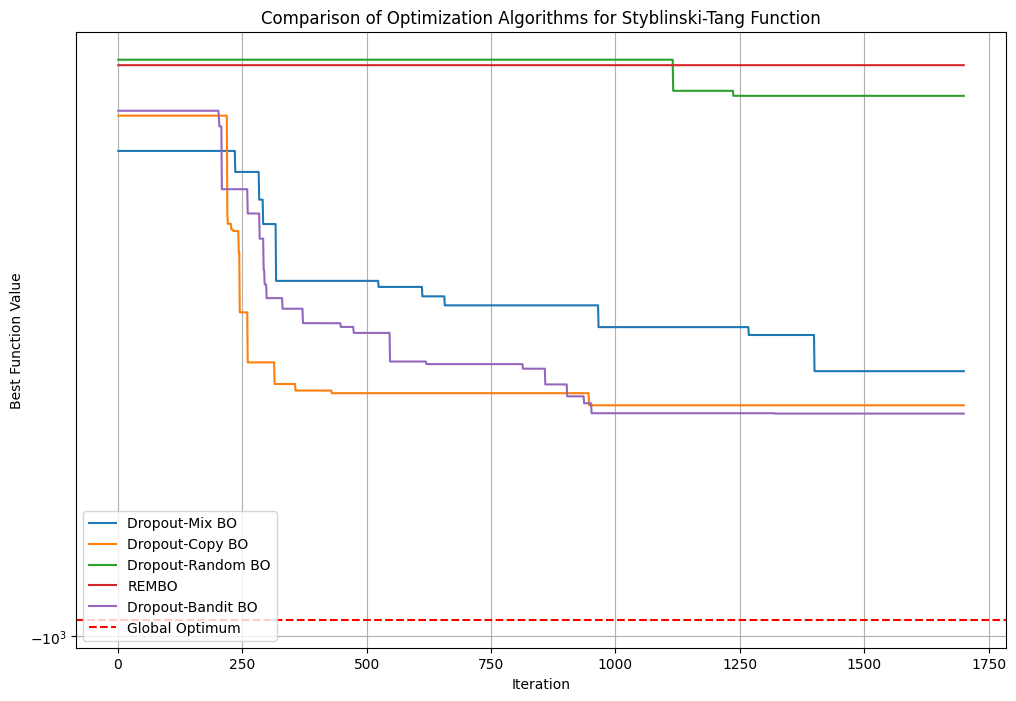

In [75]:
plt.figure(figsize=(12, 8))
plt.plot(range(1, n_initial + n_iter + 1), dropout_bo_mix.eval_history, label='Dropout-Mix BO')
plt.plot(range(1, n_initial + n_iter + 1), dropout_bo_copy.eval_history, label='Dropout-Copy BO')
plt.plot(range(1, n_initial + n_iter + 1), dropout_bo_random.eval_history, label='Dropout-Random BO')
plt.plot(range(1, n_initial + n_iter + 1), rembo.eval_history, label='REMBO')
plt.plot(range(1, n_initial + n_iter + 1), dropout_bandit.eval_history, label='Dropout-Bandit BO')
plt.axhline(y=global_optimum, color='r', linestyle='--', label='Global Optimum')
plt.xlabel('Iteration')
plt.ylabel('Best Function Value')
plt.title('Comparison of Optimization Algorithms for Styblinski-Tang Function')
plt.legend()
plt.yscale('symlog')
plt.grid(True)
plt.show()